In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

D:\anaconda\envs\segmentation_run\lib\site-packages\albumentations\augmentations\transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


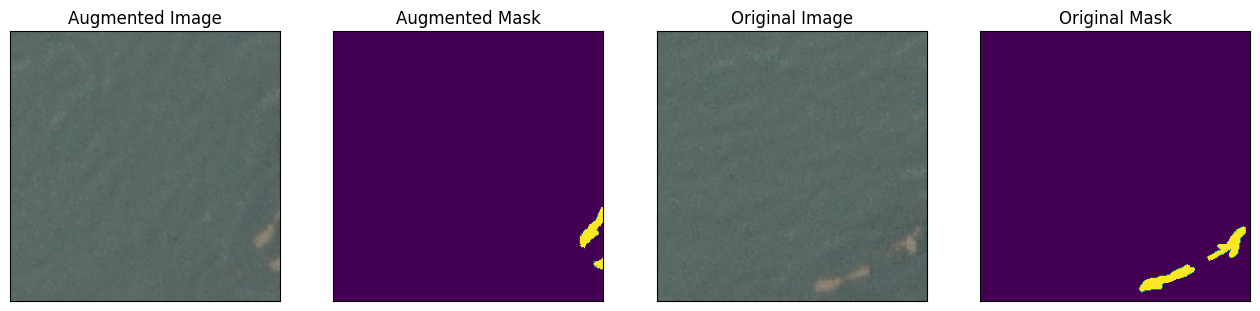

In [7]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

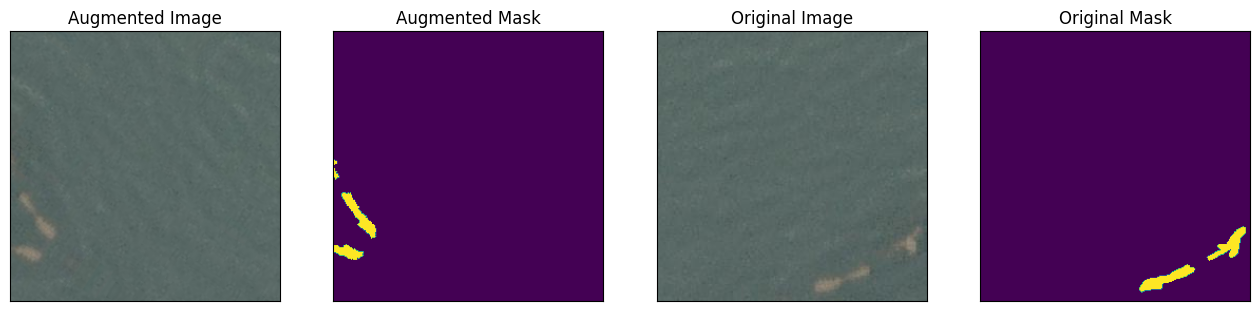

In [8]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

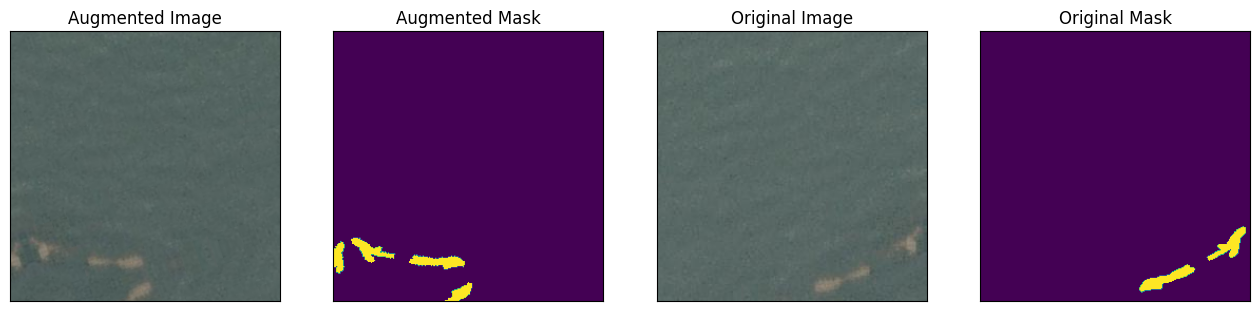

In [9]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

In [10]:
with tf.device('/GPU:0'):
    BACKBONE = 'efficientnetb7'
    BATCH_SIZE = 8
    EPOCHS = 30
    LR = 0.0001

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    preprocess_input = sm.get_preprocessing(BACKBONE)
    # define network parameters
    n_classes = 1
    activation = 'sigmoid'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # dice loss = 1 - (2 * intersection) / (union + intersection)
    dice_loss = sm.losses.DiceLoss()
    # Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
    # α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
    # p is the predicted probability of the positive class.
    # γ is the focusing parameter that controls how much the loss is focused on hard examples.
    # When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
    # the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
    focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

    total_loss = dice_loss + 1.5*focal_loss

    metrics = [sm.metrics.IOUScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, loss=total_loss, metrics=metrics)
    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_efficientnetb7_1.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(),
    ]
    #tf.config.run_functions_eagerly(True)

In [11]:
tf.config.run_functions_eagerly(False)

In [12]:
with tf.device('/GPU:0'):
    # train test split
    x_train, x_val, y_train, y_val = dataset.split_data()

    # pre processing
    x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    # define dataloader and datasets objects for train and validation data
    train_dataset = Dataset(
        x=x_train,
        y=y_train,
        augmentation=get_training_augmentation(),
        #preprocessing=get_preprocessing(preprocess_input)
    )

    valid_dataset = Dataset(
        x=x_val,
        y=y_val,
        augmentation=get_training_augmentation(),
        #preprocessing=get_preprocessing(preprocess_input)
    )

In [13]:
train_data_generator = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generate=10)
valid_data_generator = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=10)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        x=train_data_generator.dataset.x,
        y=train_data_generator.dataset.y,
        shuffle=train_data_generator.shuffle,
        batch_size=train_data_generator.batch_size,
        callbacks=callbacks,
        epochs=EPOCHS,
        validation_data=(valid_data_generator.dataset.x, valid_data_generator.dataset.y),
    )

Epoch 1/30
